In [367]:
import torch.distributions as distributions
import torch
import torch.optim as optim
from torch.nn import Parameter, Module, Linear
# from torch.nn.functional import softmax
import seaborn as sns
import matplotlib.pyplot as plt

In [383]:
class Normal(Module):
    
    def __init__(self, loc, scale):
        super(Normal, self).__init__()
        self.loc = Parameter(loc)
        self.scale = Parameter(scale)
        self.model = distributions.Normal(self.loc, self.scale)
        
    def log_prob(self, x):
        return self.model.log_prob(x)
    
    def sample(self, size):
        return self.model.rsample(size)


class GMM(Module):
    
    def __init__(self, dims=1, n_components=1):
        super(GMM, self).__init__()
        self.n_components = n_components
        self.models = [Normal(torch.tensor([torch.randn(1)]), torch.tensor([torch.rand(1)]))
                       for _ in range(n_components)]
        
    def log_prob(self, x):
        value = 0.0
        for sub_model in self.models:
            value += torch.exp(sub_model.log_prob(x))
        value /= self.n_components
        return torch.log(value+1e-6)
    
    def sample(self, size):
        value = 0.0
        for sub_model in self.models:
            value += sub_model.sample(size)
        value /= self.n_components
        return value

In [405]:
def visualize(q, p):
    q_samples = q.sample((10000,)).detach().reshape(-1).numpy()
    p_samples = p.sample((10000,)).detach().reshape(-1).numpy()
    sns.kdeplot(q_samples, cut=0, label="Q")
    sns.kdeplot(p_samples, cut=0, label="P")
    plt.show()

In [406]:
def ForwardKL(samples, distribution):
    return -distribution.log_prob(samples).sum()

def ReverseKL(q, p, batch_size=(64,)):
    samples = q.sample(batch_size)
    return -(p.log_prob(samples) - q.log_prob(samples)).sum()

In [407]:
# Forward
model = GMM(n_components=2)
truth = GMM(n_components=2) #Normal(torch.tensor([3.2]), torch.tensor([2.3]))

parameters = []
for model_i in model.models:
    parameters += list(model_i.parameters())
    
optimizer = optim.Adam(parameters, lr=0.1)

for i in range(10000):
    optimizer.zero_grad()
    samples = truth.sample((128,))
    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\n")
# print(truth.loc.item(), truth.scale.item())
# print(model.rate.item())
# visualize(model, truth)



Epoch 0 Loss: 138.158
Epoch 1000 Loss: 103.170
Epoch 2000 Loss: 113.539
Epoch 3000 Loss: 112.428
Epoch 4000 Loss: 120.915
Epoch 5000 Loss: 111.813
Epoch 6000 Loss: 99.889
Epoch 7000 Loss: 92.445
Epoch 8000 Loss: 106.795
Epoch 9000 Loss: 106.880




In [408]:
for model_i in model.models:
    print(model_i.loc, model_i.scale)

Parameter containing:
tensor([0.1611], requires_grad=True) Parameter containing:
tensor([0.5825], requires_grad=True)
Parameter containing:
tensor([0.1442], requires_grad=True) Parameter containing:
tensor([0.6204], requires_grad=True)


In [409]:
for model_i in truth.models:
    print(model_i.loc, model_i.scale)

Parameter containing:
tensor([1.1020], requires_grad=True) Parameter containing:
tensor([0.9334], requires_grad=True)
Parameter containing:
tensor([-0.8256], requires_grad=True) Parameter containing:
tensor([0.6741], requires_grad=True)


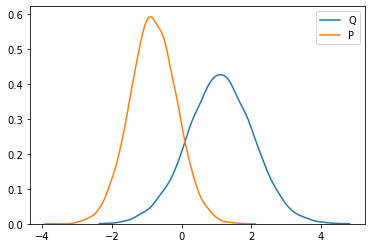

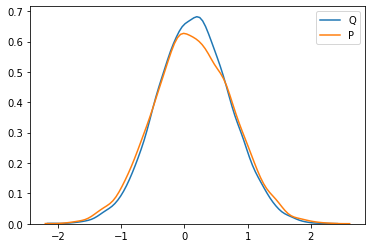

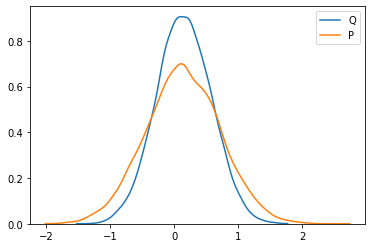

In [410]:
visualize(truth.models[0], truth.models[1])
visualize(model.models[0], model.models[1])
visualize(model, truth)

Epoch 0 Loss: -15.765




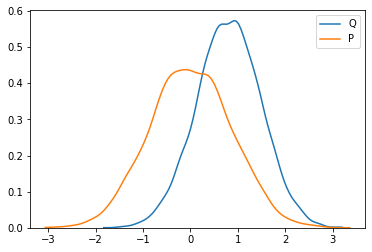

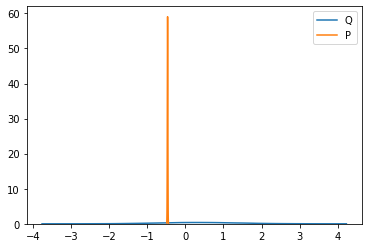

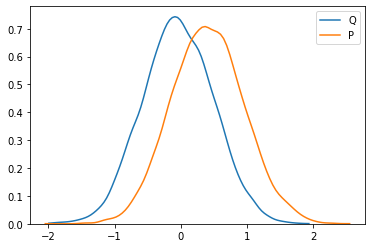

In [414]:
model = GMM(n_components=2)
truth = GMM(n_components=2)

parameters = []
for model_i in model.models:
    parameters += list(model_i.parameters())
    
optimizer = optim.Adam(parameters, lr=0.01)


for i in range(10):
    optimizer.zero_grad()
    loss = ReverseKL(model, truth)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\n")
# print(truth.loc.item(), truth.scale.item())
# print(model.rate.item())
visualize(truth.models[0], truth.models[1])
visualize(model.models[0], model.models[1])
visualize(model, truth)